# Lezione 9 — Tree-Based Models: Decision Tree e Random Forest

Questa lezione introduce i modelli basati su alberi decisionali, una delle famiglie di algoritmi più potenti e versatili per i problemi di classificazione e regressione su dati tabellari.

## Obiettivi della lezione
- Comprendere la meccanica interna di un Decision Tree.
- Capire come un albero divide lo spazio delle feature.
- Studiare i criteri di split (Gini, Entropy).
- Analizzare il problema dell'overfitting negli alberi.
- Introdurre il concetto di ensemble e Random Forest.
- Comprendere perché Random Forest generalizza meglio di un singolo albero.
- Imparare a interpretare la feature importance.

---

## Cosa sono i modelli tree-based?

I modelli tree-based sono algoritmi che costruiscono regole di decisione gerarchiche, organizzate come un albero.

Struttura di base:
- **Nodo radice**: il punto di partenza, contiene tutti i dati.
- **Nodi interni**: punti di decisione, dove i dati vengono divisi.
- **Foglie**: nodi terminali, dove viene assegnata la previsione finale.

Ogni decisione è del tipo:
```
Se feature_j ≤ soglia → vai a sinistra
Altrimenti → vai a destra
```

Il risultato è una partizione dello spazio delle feature in regioni rettangolari.

---

## Perché nascono? I limiti dei modelli lineari

I modelli lineari (regressione lineare, logistic regression) hanno un limite strutturale:

$$
\text{Confine di decisione} = w^T x + b = 0
$$

Questo confine è sempre un **iperpiano**.  
Non può catturare:
- relazioni non lineari tra feature e target;
- interazioni complesse tra variabili;
- pattern a gradini, a cluster o discontinui.

I Decision Tree superano questo limite:
- creano confini **perpendicolari agli assi**;
- possono approssimare **qualsiasi funzione** con sufficiente profondità;
- catturano **interazioni** automaticamente.

---

## Che tipo di relazioni riescono a catturare?

I Decision Tree possono modellare:

| Tipo di relazione | Modelli lineari | Decision Tree |
|-------------------|-----------------|---------------|
| Lineare | ✓ | ✓ |
| Non lineare | ✗ | ✓ |
| Interazioni tra feature | Manuale | Automatico |
| Discontinuità | ✗ | ✓ |
| Soglie (if-then) | ✗ | ✓ |

Esempio: "Se età > 30 E reddito > 50k → classe 1"  
Un modello lineare non può esprimere questa regola direttamente.  
Un Decision Tree la impara naturalmente.

---

## Collegamento con la Lezione 8

I tree-based models sono strettamente legati ai concetti di:

### Overfitting
- Un albero senza limiti può crescere fino a memorizzare ogni punto.
- Training accuracy = 100%, ma test accuracy crolla.
- La profondità dell'albero è l'iperparametro chiave.

### Bias/Variance Trade-off
- Albero poco profondo → alto bias, bassa variance → underfitting.
- Albero molto profondo → basso bias, alta variance → overfitting.
- Il punto ottimale va trovato tramite validazione.

### Generalizzazione
- Un singolo Decision Tree tende a generalizzare male.
- Random Forest risolve questo problema combinando molti alberi.
- La validazione (train/test split, cross-validation) è essenziale.

---

## Perché i tree-based models sono così popolari?

Vantaggi pratici:
1. **Non richiedono scaling** delle feature.
2. **Gestiscono valori mancanti** (in alcune implementazioni).
3. **Interpretabili** (almeno i singoli alberi).
4. **Veloci** da addestrare.
5. **Ottimi per dati tabellari** (competitivi con deep learning).
6. **Feature importance** integrata.

Svantaggi:
1. **Instabili** (piccole variazioni nei dati → alberi molto diversi).
2. **Overfitting** facile con alberi profondi.
3. **Confini solo perpendicolari** agli assi (non diagonali).

# Section 2 — Come ragiona un Decision Tree (meccanica interna)

Questa sezione spiega in dettaglio come un Decision Tree costruisce le sue regole di decisione.  
Comprendere la meccanica interna è fondamentale per usare correttamente questi modelli.

---

## 2.1 Cos'è uno split

Uno **split** è una divisione dei dati in due gruppi basata su una condizione.

La condizione ha sempre la forma:
```
feature_j ≤ threshold
```

dove:
- `feature_j` è una delle variabili del dataset;
- `threshold` è un valore numerico (soglia).

Esempio:
```
Se età ≤ 35:
    → gruppo sinistro
Altrimenti:
    → gruppo destro
```

L'algoritmo sceglie:
1. **Quale feature** usare per lo split.
2. **Quale soglia** usare.

La scelta viene fatta per massimizzare la "purezza" dei gruppi risultanti.

---

## 2.2 Cos'è una soglia (threshold)

La soglia è il valore numerico che separa i dati in due gruppi.

Come viene scelta?
1. L'algoritmo considera tutti i valori unici della feature.
2. Per ogni possibile soglia, calcola quanto lo split migliora la separazione.
3. Sceglie la soglia che produce il miglioramento maggiore.

Esempio con la feature "reddito":
```
Valori: [20k, 30k, 45k, 60k, 80k]
Possibili soglie: 25k, 37.5k, 52.5k, 70k (punti medi)
```

L'algoritmo testa ogni soglia e sceglie quella ottimale.

---

## 2.3 Come viene diviso lo spazio delle feature

Ogni split crea una **partizione rettangolare** dello spazio.

In 2D, l'effetto è questo:
```
        ┌─────────────────────────┐
        │                         │
        │    Regione A            │
        │                         │
        ├────────────┬────────────┤  ← Split su feature_1
        │            │            │
        │ Regione B  │ Regione C  │
        │            │            │
        └────────────┴────────────┘
                     ↑
              Split su feature_2
```

Ogni regione corrisponde a una foglia dell'albero.  
I confini sono sempre **perpendicolari agli assi**.

---

## 2.4 Pseudocodice dell'algoritmo

```python
def costruisci_albero(dati, profondità):
    # Caso base: fermati se i dati sono puri o profondità massima raggiunta
    if tutti_stessa_classe(dati) or profondità == max_depth:
        return Foglia(classe_più_comune(dati))
    
    # Trova il miglior split
    best_feature, best_threshold = trova_miglior_split(dati)
    
    # Dividi i dati
    dati_sinistri = dati[dati[best_feature] <= best_threshold]
    dati_destri = dati[dati[best_feature] > best_threshold]
    
    # Costruisci ricorsivamente i sottoalberi
    figlio_sinistro = costruisci_albero(dati_sinistri, profondità + 1)
    figlio_destro = costruisci_albero(dati_destri, profondità + 1)
    
    return Nodo(best_feature, best_threshold, figlio_sinistro, figlio_destro)
```

La logica di previsione è semplice:
```python
def predici(nodo, esempio):
    if nodo è una Foglia:
        return nodo.classe
    
    if esempio[nodo.feature] <= nodo.threshold:
        return predici(nodo.figlio_sinistro, esempio)
    else:
        return predici(nodo.figlio_destro, esempio)
```

---

## 2.5 Perché gli alberi NON usano combinazioni lineari

Un modello lineare calcola:
$$
z = w_1 x_1 + w_2 x_2 + \ldots + w_d x_d + b
$$

Il confine dipende da **tutte le feature insieme**.

Un Decision Tree invece:
- Considera **una feature alla volta**.
- Non crea combinazioni pesate.
- Ogni split è su una singola feature.

Conseguenze:
- Il confine è sempre parallelo a uno degli assi.
- Non può creare confini diagonali.
- Per approssimare un confine diagonale, servono molti split → albero profondo.

---

## 2.6 Perché gli alberi NON richiedono scaling

I modelli lineari sono sensibili alla scala delle feature:
- Se una feature ha valori in [0, 1000] e un'altra in [0, 1], i coefficienti sono influenzati.
- Lo scaling è necessario per trattarle equamente.

I Decision Tree invece:
- Ogni split considera una feature alla volta.
- La soglia è scelta in base ai valori effettivi della feature.
- Non c'è nessuna combinazione pesata → la scala non importa.

**Regola pratica**: con Decision Tree e Random Forest, lo scaling non è necessario.

---

## 2.7 Perché catturano interazioni tra feature

Un'interazione si verifica quando l'effetto di una feature dipende dal valore di un'altra.

Esempio: "Il rischio è alto se età > 50 **E** fumatore = sì"

Un modello lineare non può catturare questo pattern senza feature engineering.

Un Decision Tree lo impara naturalmente:
```
         [età > 50?]
         /         \
       No           Sì
       ↓             ↓
    Basso      [fumatore?]
                /       \
              No         Sì
              ↓          ↓
           Medio       Alto
```

Le interazioni emergono automaticamente dalla struttura gerarchica.

---

## 2.8 Perché sono instabili (alta variance)

L'instabilità dei Decision Tree è un problema noto:

**Causa**: piccole variazioni nei dati possono cambiare drasticamente la struttura dell'albero.

Esempio:
- Con un training set, il primo split è su "età".
- Rimuovendo pochi punti, il primo split diventa su "reddito".
- L'intero albero cambia.

**Conseguenze**:
- Due alberi addestrati su campioni simili possono dare previsioni molto diverse.
- Alta variance → overfitting.

**Soluzione**: Random Forest (combinare molti alberi instabili per ottenere stabilità).

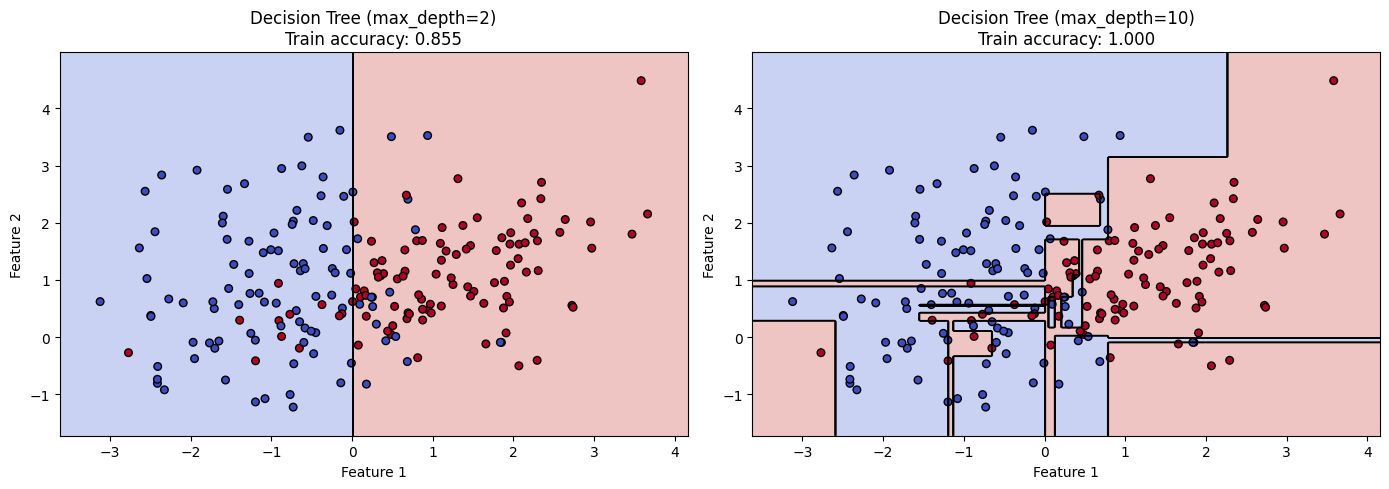

OSSERVAZIONE:
• I confini sono sempre PERPENDICOLARI agli assi (linee verticali e orizzontali)
• L'albero profondo crea regioni più piccole e specifiche → rischio overfitting
• L'albero poco profondo crea regioni grandi → potenziale underfitting


In [1]:
# Visualizzazione: come un Decision Tree divide lo spazio delle feature

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier

# Dataset semplice in 2D per visualizzazione
np.random.seed(42)
X_vis, y_vis = make_classification(
    n_samples=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=42
)

# Albero con profondità limitata
tree_shallow = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_shallow.fit(X_vis, y_vis)

# Albero profondo
tree_deep = DecisionTreeClassifier(max_depth=10, random_state=42)
tree_deep.fit(X_vis, y_vis)

# Funzione per visualizzare i confini
def plot_decision_boundary(ax, model, X, y, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    ax.contour(xx, yy, Z, colors='k', linewidths=0.5)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k', s=30)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_decision_boundary(axes[0], tree_shallow, X_vis, y_vis, 
                       f'Decision Tree (max_depth=2)\nTrain accuracy: {tree_shallow.score(X_vis, y_vis):.3f}')
plot_decision_boundary(axes[1], tree_deep, X_vis, y_vis, 
                       f'Decision Tree (max_depth=10)\nTrain accuracy: {tree_deep.score(X_vis, y_vis):.3f}')

plt.tight_layout()
plt.show()

print("OSSERVAZIONE:")
print("• I confini sono sempre PERPENDICOLARI agli assi (linee verticali e orizzontali)")
print("• L'albero profondo crea regioni più piccole e specifiche → rischio overfitting")
print("• L'albero poco profondo crea regioni grandi → potenziale underfitting")

# Section 3 — Criteri di Split (Gini ed Entropy)

Per decidere quale split effettuare, l'algoritmo deve misurare quanto un nodo è "impuro" e quanto uno split migliora la situazione.

---

## 3.1 Cos'è l'impurità

L'**impurità** misura quanto le classi sono mescolate in un nodo.

- **Nodo puro**: tutti gli esempi appartengono alla stessa classe. Impurità = 0.
- **Nodo impuro**: le classi sono mescolate. Impurità > 0.

Esempio intuitivo:
```
Nodo A: [classe1, classe1, classe1, classe1]  → Puro (impurità = 0)
Nodo B: [classe1, classe1, classe0, classe0]  → Impuro (impurità alta)
Nodo C: [classe1, classe0, classe0, classe0]  → Impuro (impurità media)
```

L'obiettivo di ogni split è **ridurre l'impurità** nei nodi figli.

---

## 3.2 Gini Impurity

La misura più comune di impurità è l'**indice di Gini**:

$$
\text{Gini}(t) = 1 - \sum_{c=1}^{C} p_c^2
$$

dove:
- $t$ è il nodo corrente;
- $C$ è il numero di classi;
- $p_c$ è la proporzione di esempi della classe $c$ nel nodo.

**Interpretazione**:
- Gini = 0 → nodo puro (tutti della stessa classe)
- Gini = 0.5 → massima impurità (per classificazione binaria con 50/50)

**Esempio** (classificazione binaria):
```
Nodo con 70% classe 1 e 30% classe 0:
Gini = 1 - (0.7² + 0.3²) = 1 - (0.49 + 0.09) = 0.42

Nodo con 100% classe 1:
Gini = 1 - (1² + 0²) = 1 - 1 = 0 (puro)

Nodo con 50% classe 1 e 50% classe 0:
Gini = 1 - (0.5² + 0.5²) = 1 - 0.5 = 0.5 (massima impurità)
```

---

## 3.3 Entropy (Entropia)

Un'alternativa al Gini è l'**entropia**:

$$
\text{Entropy}(t) = - \sum_{c=1}^{C} p_c \log_2(p_c)
$$

dove si assume che $0 \cdot \log(0) = 0$.

**Interpretazione**:
- Entropy = 0 → nodo puro
- Entropy = 1 → massima incertezza (per classificazione binaria con 50/50)

**Esempio** (classificazione binaria):
```
Nodo con 70% classe 1 e 30% classe 0:
Entropy = -0.7·log₂(0.7) - 0.3·log₂(0.3) ≈ 0.88

Nodo con 100% classe 1:
Entropy = -1·log₂(1) = 0 (puro)

Nodo con 50% classe 1 e 50% classe 0:
Entropy = -0.5·log₂(0.5) - 0.5·log₂(0.5) = 1 (massima incertezza)
```

---

## 3.4 Gini vs Entropy: differenze pratiche

| Aspetto | Gini | Entropy |
|---------|------|---------|
| Range (binario) | [0, 0.5] | [0, 1] |
| Computazione | Più veloce | Più lenta (logaritmo) |
| Risultati | Quasi identici | Quasi identici |
| Default sklearn | ✓ | |

Nella pratica:
- Gini ed Entropy producono alberi molto simili.
- Gini è leggermente più veloce.
- sklearn usa Gini di default.

---

## 3.5 Come viene scelto lo split

Per ogni possibile split, l'algoritmo calcola il **guadagno di informazione** (information gain):

$$
\text{Gain} = \text{Impurità}(padre) - \sum_{figlio} \frac{n_{figlio}}{n_{padre}} \cdot \text{Impurità}(figlio)
$$

L'algoritmo sceglie lo split che **massimizza il guadagno**.

**Esempio pratico**:
```
Nodo padre: 100 esempi, 60% classe 1, 40% classe 0
Gini padre = 1 - (0.6² + 0.4²) = 0.48

Dopo lo split:
- Figlio sinistro: 40 esempi, 80% classe 1, 20% classe 0 → Gini = 0.32
- Figlio destro: 60 esempi, 47% classe 1, 53% classe 0 → Gini = 0.50

Gini medio pesato = (40/100)·0.32 + (60/100)·0.50 = 0.43

Guadagno = 0.48 - 0.43 = 0.05
```

Se questo split ha il guadagno più alto tra tutti quelli possibili, viene scelto.

---

## 3.6 Perché lo split cerca di ridurre l'incertezza

L'obiettivo finale è creare foglie pure (o quasi pure).

Ogni split dovrebbe:
1. Separare le classi il più possibile.
2. Creare nodi figli più "omogenei" del padre.
3. Avvicinarsi a foglie con una sola classe dominante.

Se uno split non riduce l'impurità, non viene effettuato.

---

## 3.7 Intuizione visiva

```
           [50% rosso, 50% blu]  ← Nodo impuro (Gini = 0.5)
                   │
         ┌─────────┴─────────┐
         │                   │
   [90% rosso, 10% blu]  [20% rosso, 80% blu]  ← Più puri (Gini ≈ 0.18)
         │                   │
    Probabilmente       Probabilmente
       ROSSO                BLU
```

Lo split ha ridotto l'incertezza: ora possiamo fare previsioni più confidenti.

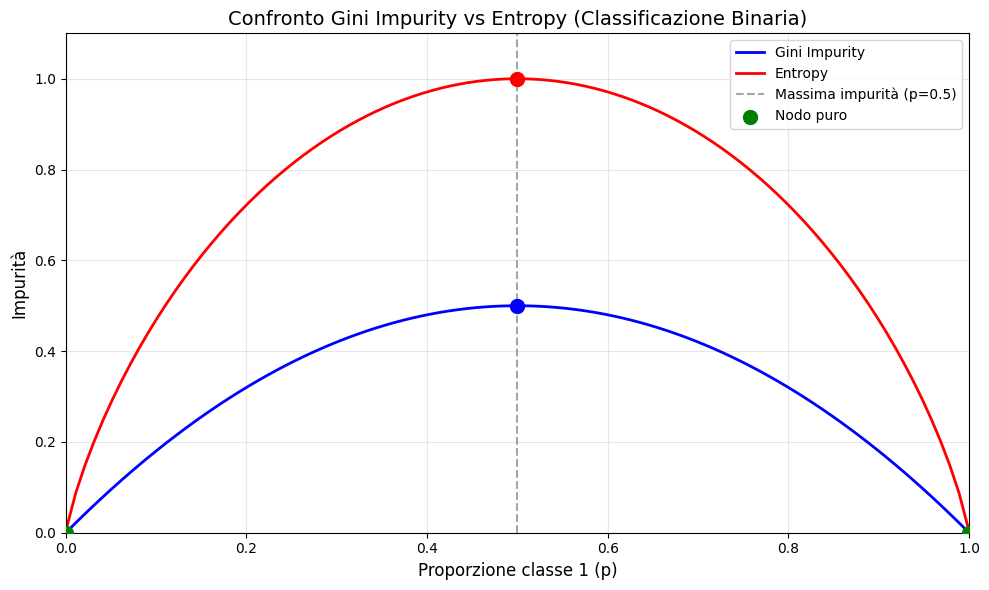

OSSERVAZIONI:
• Entrambe le misure sono 0 quando p=0 o p=1 (nodo puro)
• Entrambe raggiungono il massimo quando p=0.5 (massima incertezza)
• Le curve hanno forma simile → producono alberi simili
• Gini è leggermente più 'piatta' attorno al massimo


In [2]:
# Visualizzazione: Gini ed Entropy in funzione della proporzione di classe

import numpy as np
import matplotlib.pyplot as plt

# Range di proporzioni per classe 1 (binaria)
p = np.linspace(0.001, 0.999, 100)

# Calcolo Gini
gini = 1 - p**2 - (1-p)**2

# Calcolo Entropy
entropy = -p * np.log2(p) - (1-p) * np.log2(1-p)

# Grafico
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(p, gini, 'b-', linewidth=2, label='Gini Impurity')
ax.plot(p, entropy, 'r-', linewidth=2, label='Entropy')

# Punto di massima impurità
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='Massima impurità (p=0.5)')
ax.scatter([0.5], [0.5], color='blue', s=100, zorder=5)
ax.scatter([0.5], [1.0], color='red', s=100, zorder=5)

# Punti di purezza
ax.scatter([0, 1], [0, 0], color='green', s=100, zorder=5, label='Nodo puro')

ax.set_xlabel('Proporzione classe 1 (p)', fontsize=12)
ax.set_ylabel('Impurità', fontsize=12)
ax.set_title('Confronto Gini Impurity vs Entropy (Classificazione Binaria)', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

print("OSSERVAZIONI:")
print("• Entrambe le misure sono 0 quando p=0 o p=1 (nodo puro)")
print("• Entrambe raggiungono il massimo quando p=0.5 (massima incertezza)")
print("• Le curve hanno forma simile → producono alberi simili")
print("• Gini è leggermente più 'piatta' attorno al massimo")

# Section 4 — Overfitting nei Decision Tree

Questa sezione collega direttamente i concetti della Lezione 8 (validazione e overfitting) ai Decision Tree.  
Gli alberi decisionali sono particolarmente inclini all'overfitting, e capire perché è fondamentale per usarli correttamente.

---

## 4.1 Il comportamento naturale di un Decision Tree

Senza vincoli, un Decision Tree continua a crescere finché:
- Ogni foglia contiene un solo esempio, **oppure**
- Ogni foglia contiene esempi di una sola classe.

Questo comportamento porta a:
- Training accuracy = 100% (o quasi).
- Alberi enormi con migliaia di foglie.
- Memorizzazione del training set.

---

## 4.2 Profondità e trade-off

La **profondità** dell'albero è l'iperparametro chiave:

| Profondità | Comportamento | Rischio |
|------------|---------------|---------|
| Bassa (1-3) | Regole molto generali | Underfitting |
| Media (4-8) | Buon compromesso | Generalizzazione |
| Alta (>10) | Regole molto specifiche | Overfitting |

### Underfitting (depth bassa)
- L'albero non ha abbastanza capacità per catturare il pattern.
- Training error alto.
- Test error alto (simile al training error).
- Il modello è troppo semplice.

### Good fit (depth media)
- L'albero cattura il pattern senza adattarsi al rumore.
- Training error moderato.
- Test error simile al training error.
- Generalizzazione ottimale.

### Overfitting (depth alta)
- L'albero crea regole specifiche per singoli punti.
- Training error molto basso (~0).
- Test error significativamente più alto.
- Il modello ha memorizzato.

---

## 4.3 Perché un albero cresce finché può

L'algoritmo di costruzione dell'albero è **greedy** (avido):
- A ogni passo, cerca il miglior split locale.
- Non considera le conseguenze future.
- Continua finché non trova più split utili.

Senza limiti espliciti:
```
Profondità 1: divide in 2 regioni
Profondità 2: divide in 4 regioni
Profondità 3: divide in 8 regioni
...
Profondità 10: divide in 1024 regioni
...
Profondità 20: divide in 1.048.576 regioni
```

Con 1000 esempi, un albero di profondità 10 potrebbe avere una foglia per ogni esempio.

---

## 4.4 Perché può "memorizzare" il training set

Consideriamo un dataset con rumore:

```
Esempio 1: [età=35, reddito=50k] → classe 1
Esempio 2: [età=35, reddito=51k] → classe 0  ← rumore (dovrebbe essere classe 1)
```

Un albero profondo può creare:
```
Se età == 35:
    Se reddito <= 50.5k:
        → classe 1
    Altrimenti:
        → classe 0
```

Ha memorizzato l'errore dell'esempio 2.  
Su nuovi dati, questa regola sarà sbagliata.

---

## 4.5 Perché un singolo albero generalizza male

Tre motivi fondamentali:

### 1. Alta variance
- Piccole variazioni nei dati → alberi molto diversi.
- Le previsioni sono instabili.

### 2. Adattamento al rumore
- L'albero impara le particolarità del training set.
- Queste particolarità non si ripetono nei nuovi dati.

### 3. Confini troppo specifici
- Ogni foglia corrisponde a una regione dello spazio.
- Regioni troppo piccole non generalizzano.

---

## 4.6 Come controllare l'overfitting

Scikit-learn offre diversi iperparametri per limitare la crescita:

| Parametro | Significato | Effetto |
|-----------|-------------|---------|
| `max_depth` | Profondità massima | Limita la complessità verticale |
| `min_samples_split` | Min campioni per split | Evita split su pochi dati |
| `min_samples_leaf` | Min campioni per foglia | Evita foglie troppo piccole |
| `max_leaf_nodes` | Numero massimo di foglie | Limita la complessità totale |
| `max_features` | Feature da considerare per split | Riduce la varianza |

Il più importante è `max_depth`: inizia sempre da qui.

---

## 4.7 Strategia pratica

1. **Parti con un albero poco profondo** (max_depth=3-5).
2. **Aumenta gradualmente** la profondità.
3. **Monitora il gap** tra training e test/validation score.
4. **Ferma** quando il test score inizia a peggiorare.
5. **Usa cross-validation** per stime più robuste.

# Section 5 — Dimostrazione Guidata: Decision Tree

Questa sezione presenta una dimostrazione pratica completa del comportamento di un Decision Tree al variare della profondità.

---

## 5.1 Obiettivo della dimostrazione

Vogliamo osservare empiricamente:
1. Come il training score aumenta con la profondità.
2. Come il test score prima migliora e poi peggiora.
3. A quale profondità inizia l'overfitting.
4. La relazione tra profondità e gap train/test.

In [3]:
# Dimostrazione: Decision Tree con profondità crescente

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Generazione dataset con rumore
X, y = make_classification(
    n_samples=800,
    n_features=15,
    n_informative=8,
    n_redundant=3,
    n_clusters_per_class=2,
    flip_y=0.1,  # 10% di rumore nelle etichette
    random_state=42
)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print(f"Training set: {X_train.shape[0]} campioni")
print(f"Test set: {X_test.shape[0]} campioni")
print(f"Rumore nelle etichette: 10%")
print()

# Range di profondità da testare
depths = range(1, 21)

# Memorizzazione risultati
train_scores = []
test_scores = []

print("="*65)
print(f"{'Depth':<8} {'Train Acc':<12} {'Test Acc':<12} {'Gap':<10} {'Status'}")
print("="*65)

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    
    train_acc = dt.score(X_train, y_train)
    test_acc = dt.score(X_test, y_test)
    gap = train_acc - test_acc
    
    train_scores.append(train_acc)
    test_scores.append(test_acc)
    
    # Determina lo status
    if gap > 0.15:
        status = "⚠️  OVERFITTING"
    elif train_acc < 0.75:
        status = "📉 UNDERFITTING"
    elif gap < 0.05:
        status = "✓  OTTIMO"
    else:
        status = "~  OK"
    
    print(f"{depth:<8} {train_acc:<12.4f} {test_acc:<12.4f} {gap:<10.4f} {status}")

print("="*65)

# Trova la profondità ottimale
optimal_depth = depths[np.argmax(test_scores)]
print(f"\nProfondità ottimale (max test accuracy): {optimal_depth}")
print(f"Test accuracy massima: {max(test_scores):.4f}")

Training set: 600 campioni
Test set: 200 campioni
Rumore nelle etichette: 10%

Depth    Train Acc    Test Acc     Gap        Status
1        0.6917       0.6650       0.0267     📉 UNDERFITTING
2        0.7633       0.7500       0.0133     ✓  OTTIMO
3        0.8517       0.8700       -0.0183    ✓  OTTIMO
4        0.8850       0.8800       0.0050     ✓  OTTIMO
5        0.9250       0.8650       0.0600     ~  OK
6        0.9567       0.8300       0.1267     ~  OK
7        0.9800       0.8300       0.1500     ⚠️  OVERFITTING
8        0.9883       0.8200       0.1683     ⚠️  OVERFITTING
9        0.9967       0.8200       0.1767     ⚠️  OVERFITTING
10       1.0000       0.7900       0.2100     ⚠️  OVERFITTING
11       1.0000       0.7900       0.2100     ⚠️  OVERFITTING
12       1.0000       0.7900       0.2100     ⚠️  OVERFITTING
13       1.0000       0.7900       0.2100     ⚠️  OVERFITTING
14       1.0000       0.7900       0.2100     ⚠️  OVERFITTING
15       1.0000       0.7900       0.21

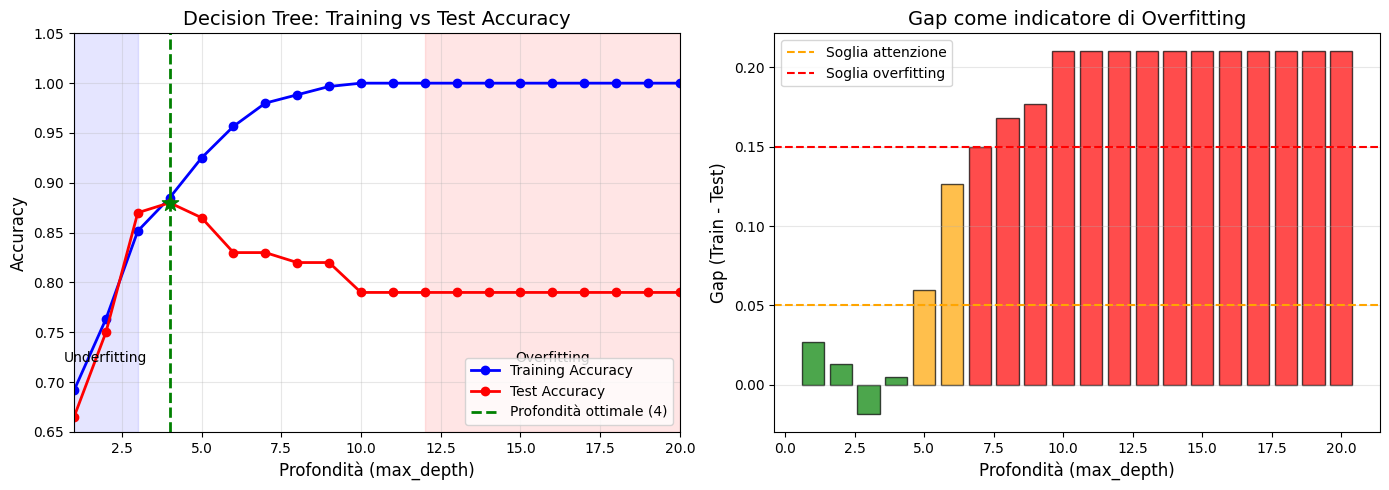


ANALISI DEI RISULTATI

OSSERVAZIONI CHIAVE:

1. TRAINING ACCURACY:
   - Cresce monotonamente con la profondità
   - Raggiunge ~100% per alberi profondi
   - NON è un indicatore affidabile della qualità del modello

2. TEST ACCURACY:
   - Cresce inizialmente (il modello impara il pattern)
   - Raggiunge un massimo (punto ottimale)
   - Poi decresce (il modello inizia a memorizzare)

3. IL GAP:
   - Gap piccolo → buona generalizzazione
   - Gap grande → overfitting
   - Il gap cresce con la profondità

4. CONCLUSIONE:
   - Un albero troppo profondo MEMORIZZA invece di IMPARARE
   - La profondità va scelta tramite validazione, non intuizione



In [4]:
# Visualizzazione grafica dell'overfitting

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grafico 1: Training vs Test Accuracy
ax1 = axes[0]
ax1.plot(list(depths), train_scores, 'b-o', linewidth=2, markersize=6, label='Training Accuracy')
ax1.plot(list(depths), test_scores, 'r-o', linewidth=2, markersize=6, label='Test Accuracy')

# Evidenzia la profondità ottimale
ax1.axvline(x=optimal_depth, color='green', linestyle='--', linewidth=2, 
            label=f'Profondità ottimale ({optimal_depth})')
ax1.scatter([optimal_depth], [max(test_scores)], color='green', s=150, zorder=5, marker='*')

# Zone
ax1.axvspan(1, 3, alpha=0.1, color='blue')
ax1.axvspan(12, 20, alpha=0.1, color='red')
ax1.annotate('Underfitting', xy=(2, 0.72), fontsize=10, ha='center')
ax1.annotate('Overfitting', xy=(16, 0.72), fontsize=10, ha='center')

ax1.set_xlabel('Profondità (max_depth)', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Decision Tree: Training vs Test Accuracy', fontsize=14)
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1, 20)
ax1.set_ylim(0.65, 1.05)

# Grafico 2: Gap tra Training e Test
ax2 = axes[1]
gaps = np.array(train_scores) - np.array(test_scores)
colors = ['green' if g < 0.05 else 'orange' if g < 0.15 else 'red' for g in gaps]
ax2.bar(list(depths), gaps, color=colors, edgecolor='black', alpha=0.7)
ax2.axhline(y=0.05, color='orange', linestyle='--', label='Soglia attenzione')
ax2.axhline(y=0.15, color='red', linestyle='--', label='Soglia overfitting')

ax2.set_xlabel('Profondità (max_depth)', fontsize=12)
ax2.set_ylabel('Gap (Train - Test)', fontsize=12)
ax2.set_title('Gap come indicatore di Overfitting', fontsize=14)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*65)
print("ANALISI DEI RISULTATI")
print("="*65)
print("""
OSSERVAZIONI CHIAVE:

1. TRAINING ACCURACY:
   - Cresce monotonamente con la profondità
   - Raggiunge ~100% per alberi profondi
   - NON è un indicatore affidabile della qualità del modello

2. TEST ACCURACY:
   - Cresce inizialmente (il modello impara il pattern)
   - Raggiunge un massimo (punto ottimale)
   - Poi decresce (il modello inizia a memorizzare)

3. IL GAP:
   - Gap piccolo → buona generalizzazione
   - Gap grande → overfitting
   - Il gap cresce con la profondità

4. CONCLUSIONE:
   - Un albero troppo profondo MEMORIZZA invece di IMPARARE
   - La profondità va scelta tramite validazione, non intuizione
""")

# Section 6 — Random Forest: Perché Esiste

Il Random Forest nasce per risolvere il problema principale dei Decision Tree: l'alta variance e la tendenza all'overfitting.

---

## 6.1 Il problema fondamentale dei Decision Tree

Abbiamo visto che i Decision Tree:
- Sono instabili: piccole variazioni nei dati → alberi molto diversi.
- Tendono a memorizzare: alberi profondi overfittano.
- Hanno alta variance: le previsioni cambiano molto con training set diversi.

La domanda è: come ottenere i vantaggi degli alberi senza gli svantaggi?

---

## 6.2 L'idea di Ensemble

Un **ensemble** combina più modelli per ottenere previsioni migliori.

Intuizione statistica:
- Un singolo modello può sbagliare in modo specifico.
- Se combiniamo molti modelli diversi, gli errori tendono a **cancellarsi**.
- La media di molte stime rumorose è più stabile di una singola stima.

Analogia:
- Chiedere l'opinione a un singolo esperto → rischio di bias personale.
- Chiedere a 100 esperti e fare la media → stima più robusta.

---

## 6.3 Bagging (Bootstrap Aggregating)

Il **bagging** è la tecnica alla base del Random Forest:

1. **Bootstrap sampling**: crea $B$ campioni dal training set, estraendo $n$ esempi con reinserimento.
2. **Addestramento**: addestra un modello su ogni campione bootstrap.
3. **Aggregazione**: combina le previsioni (media per regressione, voto per classificazione).

```
Training Set originale: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Bootstrap sample 1: [2, 5, 5, 8, 1, 9, 3, 8, 2, 7]  → Albero 1
Bootstrap sample 2: [4, 1, 9, 9, 6, 2, 8, 3, 1, 5]  → Albero 2
Bootstrap sample 3: [7, 3, 3, 6, 10, 4, 2, 8, 9, 1] → Albero 3
...

Previsione finale = Voto di maggioranza (o media)
```

Nota: ogni sample bootstrap contiene circa il 63% degli esempi originali (alcuni ripetuti), il 37% è escluso ("out-of-bag").

---

## 6.4 Bootstrap Sampling in dettaglio

Il **campionamento con reinserimento** significa:
- Estrai un esempio casualmente.
- Rimettilo nel dataset.
- Ripeti $n$ volte.

Conseguenze:
- Alcuni esempi appariranno più volte.
- Altri non appariranno mai (circa 37%).
- Ogni campione bootstrap è diverso.
- Gli alberi addestrati saranno diversi.

Matematicamente, la probabilità che un esempio non sia selezionato dopo $n$ estrazioni:
$$
P(\text{escluso}) = \left(1 - \frac{1}{n}\right)^n \approx e^{-1} \approx 0.368
$$

---

## 6.5 Perché molti alberi "deboli" funzionano meglio di uno forte

Un singolo albero profondo:
- È molto specifico per il training set.
- Ha bassa bias ma alta variance.
- Le sue previsioni sono instabili.

Molti alberi poco profondi (o diversificati):
- Ognuno è leggermente sbagliato in modo diverso.
- La media/voto cancella gli errori casuali.
- Il risultato è più stabile.

Questa è l'essenza del **wisdom of crowds** applicato al machine learning.

---

## 6.6 Random Forest: oltre il bagging

Random Forest aggiunge un ulteriore elemento di casualità:

**Random feature selection**: a ogni split, considera solo un sottoinsieme casuale delle feature.

```
Feature disponibili: [f1, f2, f3, f4, f5, f6, f7, f8]

Split 1: considera solo [f2, f5, f7]     → sceglie il migliore tra questi
Split 2: considera solo [f1, f4, f8]     → sceglie il migliore tra questi
Split 3: considera solo [f3, f6, f7]     → sceglie il migliore tra questi
...
```

Tipicamente: $\sqrt{p}$ feature per classificazione, $p/3$ per regressione.

Perché funziona:
- Se una feature è molto forte, tutti gli alberi la userebbero → alberi correlati.
- Forzando la diversità, gli alberi diventano **decorrelati**.
- Alberi decorrelati → errori che si cancellano meglio.

---

## 6.7 Riduzione della Variance

Random Forest riduce la variance senza aumentare il bias.

Matematicamente, per $B$ modelli indipendenti con variance $\sigma^2$:
$$
\text{Var}(\text{media}) = \frac{\sigma^2}{B}
$$

Se i modelli sono correlati (correlazione $\rho$):
$$
\text{Var}(\text{media}) = \rho \sigma^2 + \frac{1-\rho}{B} \sigma^2
$$

La random feature selection riduce $\rho$ → migliore riduzione della variance.

---

## 6.8 Perché Random Forest generalizza meglio

| Aspetto | Decision Tree | Random Forest |
|---------|---------------|---------------|
| Variance | Alta | Bassa (media di molti) |
| Stabilità | Bassa | Alta |
| Overfitting | Facile | Più difficile |
| Bias | Basso (se profondo) | Leggermente più alto |
| Robustezza al rumore | Bassa | Alta |

Il Random Forest:
- Mantiene la capacità di catturare non-linearità.
- Riduce drasticamente la variance.
- Generalizza molto meglio.

---

## 6.9 Iperparametri principali di Random Forest

| Parametro | Significato | Valore tipico |
|-----------|-------------|---------------|
| `n_estimators` | Numero di alberi | 100-500 |
| `max_depth` | Profondità max per albero | None o 10-30 |
| `max_features` | Feature per split | 'sqrt' o 'log2' |
| `min_samples_split` | Min campioni per split | 2-10 |
| `min_samples_leaf` | Min campioni per foglia | 1-5 |
| `bootstrap` | Usare bootstrap sampling | True |

Nota: con più alberi (`n_estimators`), il modello è sempre migliore o uguale (no overfitting da troppi alberi).

# Section 7 — Dimostrazione Guidata: Random Forest vs Decision Tree

Questa sezione confronta direttamente le prestazioni di un Decision Tree singolo con un Random Forest sullo stesso dataset.

---

## 7.1 Obiettivo della dimostrazione

Vogliamo osservare:
1. La differenza di performance tra Decision Tree e Random Forest.
2. La maggiore stabilità del Random Forest.
3. Come il gap train/test cambia tra i due modelli.
4. L'effetto del numero di alberi nel Random Forest.

In [5]:
# Dimostrazione: Confronto Decision Tree vs Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Usiamo lo stesso dataset della sezione precedente (X_train, X_test, y_train, y_test)

# Definiamo i modelli da confrontare
models = {
    'Decision Tree (depth=3)': DecisionTreeClassifier(max_depth=3, random_state=42),
    'Decision Tree (depth=10)': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Decision Tree (unlimited)': DecisionTreeClassifier(random_state=42),
    'Random Forest (100 trees)': RandomForestClassifier(n_estimators=100, random_state=42),
    'Random Forest (depth=5)': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
}

print("="*80)
print("CONFRONTO DECISION TREE vs RANDOM FOREST")
print("="*80)
print(f"\n{'Modello':<30} {'Train Acc':<12} {'Test Acc':<12} {'Gap':<10} {'CV Mean±Std'}")
print("-"*80)

results = {}
for name, model in models.items():
    # Addestramento
    model.fit(X_train, y_train)
    
    # Score
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    gap = train_acc - test_acc
    
    # Cross-validation per stabilità
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    
    results[name] = {
        'train': train_acc,
        'test': test_acc,
        'gap': gap,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    print(f"{name:<30} {train_acc:<12.4f} {test_acc:<12.4f} {gap:<10.4f} {cv_scores.mean():.4f}±{cv_scores.std():.4f}")

print("-"*80)

CONFRONTO DECISION TREE vs RANDOM FOREST

Modello                        Train Acc    Test Acc     Gap        CV Mean±Std
--------------------------------------------------------------------------------
Decision Tree (depth=3)        0.8517       0.8700       -0.0183    0.8000±0.0395
Decision Tree (depth=10)       1.0000       0.7900       0.2100     0.7925±0.0275
Decision Tree (unlimited)      1.0000       0.7900       0.2100     0.7925±0.0275
Random Forest (100 trees)      1.0000       0.8350       0.1650     0.8550±0.0386
Random Forest (depth=5)        0.9417       0.8200       0.1217     0.8363±0.0325
--------------------------------------------------------------------------------


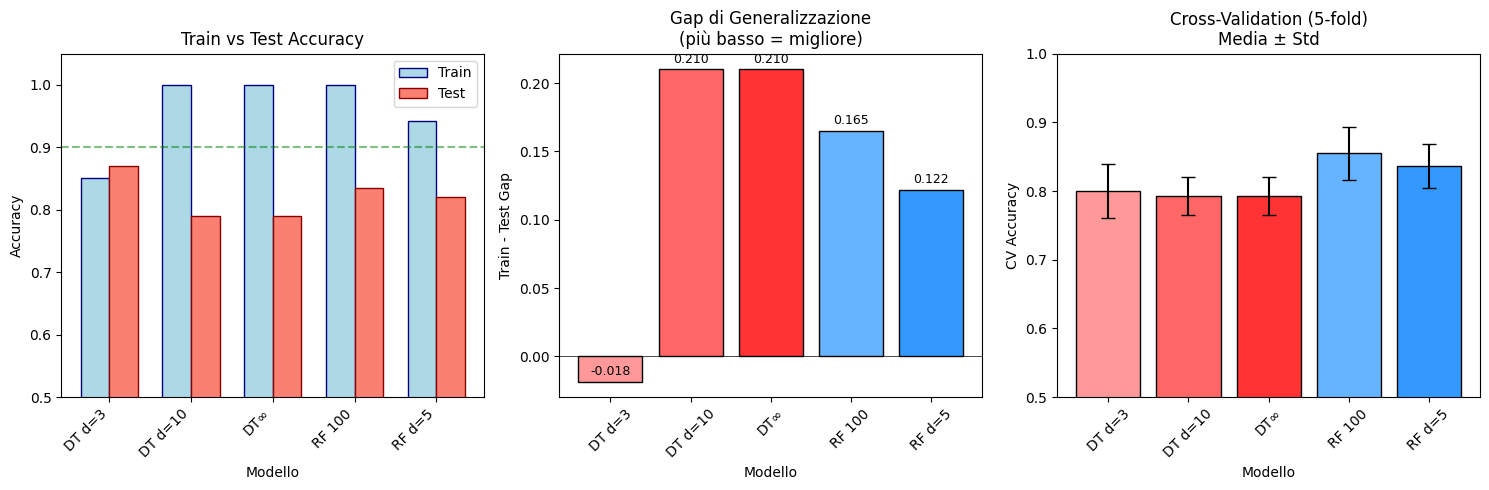


📊 INTERPRETAZIONE:
------------------------------------------------------------
• I Decision Tree senza limiti (DT∞) mostrano overfitting elevato
• Il Random Forest riduce la varianza tramite l'ensemble
• RF con limitazione di profondità (d=5) bilancia bias e varianza
• La cross-validation mostra che RF ha deviazione standard più bassa


In [6]:
# Visualizzazione del confronto

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

model_names = list(results.keys())
train_accs = [results[m]['train'] for m in model_names]
test_accs = [results[m]['test'] for m in model_names]
gaps = [results[m]['gap'] for m in model_names]
cv_means = [results[m]['cv_mean'] for m in model_names]
cv_stds = [results[m]['cv_std'] for m in model_names]

# Short names per grafico
short_names = ['DT d=3', 'DT d=10', 'DT∞', 'RF 100', 'RF d=5']
colors = ['#ff9999', '#ff6666', '#ff3333', '#66b3ff', '#3399ff']

# Subplot 1: Train vs Test accuracy
x = np.arange(len(short_names))
width = 0.35
bars1 = axes[0].bar(x - width/2, train_accs, width, label='Train', color='lightblue', edgecolor='navy')
bars2 = axes[0].bar(x + width/2, test_accs, width, label='Test', color='salmon', edgecolor='darkred')
axes[0].set_xlabel('Modello')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Train vs Test Accuracy')
axes[0].set_xticks(x)
axes[0].set_xticklabels(short_names, rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim([0.5, 1.05])
axes[0].axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='Soglia 90%')

# Subplot 2: Gap (overfitting indicator)
axes[1].bar(short_names, gaps, color=colors, edgecolor='black')
axes[1].set_xlabel('Modello')
axes[1].set_ylabel('Train - Test Gap')
axes[1].set_title('Gap di Generalizzazione\n(più basso = migliore)')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
for i, v in enumerate(gaps):
    axes[1].text(i, v + 0.005, f'{v:.3f}', ha='center', fontsize=9)
axes[1].tick_params(axis='x', rotation=45)

# Subplot 3: Cross-validation con barre di errore
axes[2].bar(short_names, cv_means, yerr=cv_stds, color=colors, edgecolor='black', capsize=5)
axes[2].set_xlabel('Modello')
axes[2].set_ylabel('CV Accuracy')
axes[2].set_title('Cross-Validation (5-fold)\nMedia ± Std')
axes[2].set_ylim([0.5, 1.0])
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n📊 INTERPRETAZIONE:")
print("-" * 60)
print("• I Decision Tree senza limiti (DT∞) mostrano overfitting elevato")
print("• Il Random Forest riduce la varianza tramite l'ensemble")
print("• RF con limitazione di profondità (d=5) bilancia bias e varianza")
print("• La cross-validation mostra che RF ha deviazione standard più bassa")

# Section 8 — Feature Importance

## 8.1 — Cos'è la Feature Importance?

La **Feature Importance** misura quanto ciascuna feature contribuisce alle decisioni del modello. È uno strumento fondamentale per:

1. **Interpretabilità**: Capire quali variabili guidano le predizioni
2. **Feature Selection**: Identificare feature irrilevanti da eliminare
3. **Domain Knowledge**: Validare che il modello usi feature sensate
4. **Debugging**: Individuare data leakage o problemi nei dati

## 8.2 — Come Viene Calcolata

### Decision Tree
La feature importance in un Decision Tree si basa sulla **riduzione totale dell'impurità** (Gini o Entropy) prodotta da quella feature:

$$\text{Importance}(f) = \sum_{t \in \text{nodi che usano } f} \frac{n_t}{N} \cdot \Delta \text{Impurità}(t)$$

Dove:
- $n_t$ = numero di campioni nel nodo $t$
- $N$ = numero totale di campioni
- $\Delta \text{Impurità}(t)$ = riduzione di impurità nello split del nodo $t$

### Random Forest
Nel Random Forest, la feature importance è la **media delle importanze** calcolate su tutti gli alberi dell'ensemble:

$$\text{Importance}_{RF}(f) = \frac{1}{B} \sum_{b=1}^{B} \text{Importance}_{tree_b}(f)$$

Questo rende la stima più stabile e robusta rispetto a un singolo albero.

## 8.3 — Attenzione alle Correlazioni

⚠️ **Problema**: Se due feature sono altamente correlate:
- Il modello potrebbe usare arbitrariamente l'una o l'altra
- L'importanza viene "divisa" tra le due
- Nessuna delle due appare molto importante singolarmente

**Soluzione**: Analizzare le correlazioni prima di interpretare le importanze, oppure usare tecniche come Permutation Importance.

In [7]:
# Dimostrazione: Feature Importance

# Creiamo un dataset con feature di diversa rilevanza
np.random.seed(42)
n_samples = 500

# Feature informative
X_imp = np.random.randn(n_samples, 10)
feature_names = [f'Feature_{i}' for i in range(10)]

# Target: dipende solo da alcune feature (0, 1, 2 molto importanti, 3 mediamente, resto rumore)
y_imp = (2*X_imp[:, 0] + 1.5*X_imp[:, 1] - X_imp[:, 2] + 0.5*X_imp[:, 3] + np.random.randn(n_samples)*0.5 > 0).astype(int)

X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_imp, y_imp, test_size=0.2, random_state=42)

# Addestra Decision Tree e Random Forest
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

dt_model.fit(X_train_imp, y_train_imp)
rf_model.fit(X_train_imp, y_train_imp)

# Estrai feature importances
dt_importance = dt_model.feature_importances_
rf_importance = rf_model.feature_importances_

print("="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)
print(f"\n{'Feature':<15} {'DT Importance':<18} {'RF Importance':<18} {'True Role'}")
print("-"*70)

true_roles = ['⭐ Molto importante', '⭐ Molto importante', '⭐ Molto importante', 
              '📊 Mediamente', '❌ Rumore', '❌ Rumore', '❌ Rumore', 
              '❌ Rumore', '❌ Rumore', '❌ Rumore']

for i, name in enumerate(feature_names):
    print(f"{name:<15} {dt_importance[i]:<18.4f} {rf_importance[i]:<18.4f} {true_roles[i]}")

print("-"*70)
print(f"{'TOTALE':<15} {dt_importance.sum():<18.4f} {rf_importance.sum():<18.4f}")
print("\n💡 Le feature 0, 1, 2 dovrebbero avere importanza alta, 3 media, resto bassa")

FEATURE IMPORTANCE ANALYSIS

Feature         DT Importance      RF Importance      True Role
----------------------------------------------------------------------
Feature_0       0.4057             0.3477             ⭐ Molto importante
Feature_1       0.3353             0.2921             ⭐ Molto importante
Feature_2       0.1800             0.1578             ⭐ Molto importante
Feature_3       0.0536             0.0483             📊 Mediamente
Feature_4       0.0000             0.0164             ❌ Rumore
Feature_5       0.0254             0.0328             ❌ Rumore
Feature_6       0.0000             0.0321             ❌ Rumore
Feature_7       0.0000             0.0233             ❌ Rumore
Feature_8       0.0000             0.0254             ❌ Rumore
Feature_9       0.0000             0.0242             ❌ Rumore
----------------------------------------------------------------------
TOTALE          1.0000             1.0000            

💡 Le feature 0, 1, 2 dovrebbero avere importan

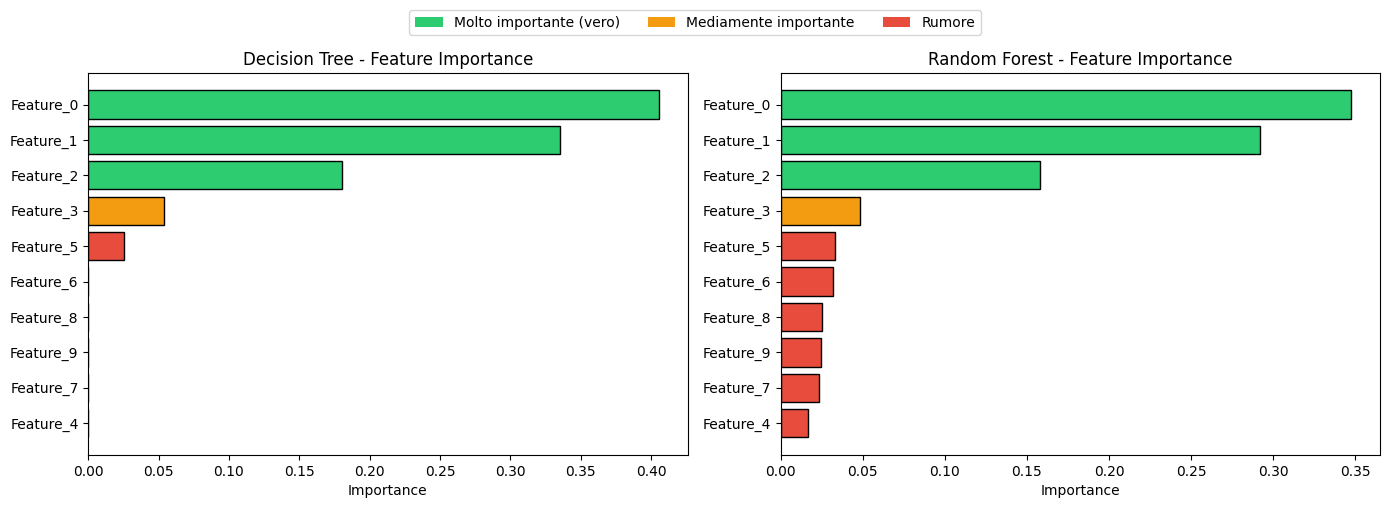


📊 OSSERVAZIONI:
------------------------------------------------------------
• Random Forest produce stime più stabili dell'importanza
• Decision Tree può dare peso eccessivo a feature rumorose
• Entrambi identificano correttamente le feature più rilevanti
• Le feature di rumore (rosse) hanno correttamente importanza bassa


In [8]:
# Visualizzazione Feature Importance: DT vs RF

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ordina per importanza RF
sorted_idx = np.argsort(rf_importance)[::-1]

# Colori basati sulla vera importanza
colors_imp = ['#2ecc71' if i < 3 else '#f39c12' if i == 3 else '#e74c3c' for i in sorted_idx]

# Plot 1: Decision Tree
axes[0].barh(range(10), dt_importance[sorted_idx], color=colors_imp, edgecolor='black')
axes[0].set_yticks(range(10))
axes[0].set_yticklabels([feature_names[i] for i in sorted_idx])
axes[0].set_xlabel('Importance')
axes[0].set_title('Decision Tree - Feature Importance')
axes[0].invert_yaxis()

# Plot 2: Random Forest
axes[1].barh(range(10), rf_importance[sorted_idx], color=colors_imp, edgecolor='black')
axes[1].set_yticks(range(10))
axes[1].set_yticklabels([feature_names[i] for i in sorted_idx])
axes[1].set_xlabel('Importance')
axes[1].set_title('Random Forest - Feature Importance')
axes[1].invert_yaxis()

# Legenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='Molto importante (vero)'),
    Patch(facecolor='#f39c12', label='Mediamente importante'),
    Patch(facecolor='#e74c3c', label='Rumore')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

print("\n📊 OSSERVAZIONI:")
print("-" * 60)
print("• Random Forest produce stime più stabili dell'importanza")
print("• Decision Tree può dare peso eccessivo a feature rumorose")
print("• Entrambi identificano correttamente le feature più rilevanti")
print("• Le feature di rumore (rosse) hanno correttamente importanza bassa")

# Section 9 — Esercizi Guidati

Questa sezione contiene esercizi pratici per consolidare i concetti appresi. Ogni esercizio richiede di completare il codice nei punti indicati con `# TODO`.

---

## Esercizio 9.1 — Effetto della Profondità sul Decision Tree

**Obiettivo**: Analizzare come la profondità massima influenza le performance di un Decision Tree.

**Istruzioni**:
1. Crea un dataset con `make_classification`
2. Prova diversi valori di `max_depth` (da 1 a 15)
3. Per ogni profondità, calcola accuracy su train e test
4. Visualizza i risultati e identifica la profondità ottimale

In [ ]:
# ESERCIZIO 9.1 — Effetto della Profondità

from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Crea il dataset
X_ex, y_ex = make_classification(
    n_samples=600, 
    n_features=10, 
    n_informative=5, 
    n_redundant=2,
    random_state=42
)

# Split train/test
X_train_ex, X_test_ex, y_train_ex, y_test_ex = train_test_split(
    X_ex, y_ex, test_size=0.25, random_state=42
)

# Definisci una lista di valori di max_depth da testare (da 1 a 15)
depths = range(1, 16)

# Crea liste vuote per salvare le accuracy
train_accuracies = []
test_accuracies = []

# Loop su ogni profondità
for depth in depths:
    # Crea e addestra un DecisionTreeClassifier con max_depth=depth
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    
    # Addestra il modello
    dt.fit(X_train_ex, y_train_ex)
    
    # Calcola accuracy su train e test
    train_acc = dt.score(X_train_ex, y_train_ex)
    test_acc = dt.score(X_test_ex, y_test_ex)
    
    # Appendi alle liste
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Visualizza i risultati con un grafico a linee
plt.figure(figsize=(10, 6))
plt.plot(list(depths), train_accuracies, 'b-o', linewidth=2, label='Training Accuracy')
plt.plot(list(depths), test_accuracies, 'r-o', linewidth=2, label='Test Accuracy')
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Effetto della Profondità su Decision Tree', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.xticks(list(depths))
plt.tight_layout()
plt.show()

# Trova e stampa la profondità ottimale (quella con massimo test accuracy)
optimal_depth = list(depths)[np.argmax(test_accuracies)]
max_test_acc = max(test_accuracies)
print(f"\nProfondità ottimale: {optimal_depth}")
print(f"Test accuracy massima: {max_test_acc:.4f}")

---

## Esercizio 9.2 — Confronto Criterio di Split: Gini vs Entropy

**Obiettivo**: Verificare empiricamente se Gini ed Entropy producono risultati diversi.

**Istruzioni**:
1. Usa lo stesso dataset dell'esercizio precedente
2. Addestra due Decision Tree: uno con `criterion='gini'`, uno con `criterion='entropy'`
3. Confronta le performance usando cross-validation
4. Confronta anche il numero di nodi/foglie degli alberi risultanti

In [ ]:
# ESERCIZIO 9.2 — Gini vs Entropy

from sklearn.model_selection import cross_val_score

# Crea un DecisionTreeClassifier con criterion='gini' e max_depth=5
dt_gini = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)

# Crea un DecisionTreeClassifier con criterion='entropy' e max_depth=5
dt_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

# Calcola cross_val_score (5 fold) per entrambi i modelli usando X_ex, y_ex
cv_gini = cross_val_score(dt_gini, X_ex, y_ex, cv=5, scoring='accuracy')
cv_entropy = cross_val_score(dt_entropy, X_ex, y_ex, cv=5, scoring='accuracy')

# Stampa i risultati
print("Confronto Gini vs Entropy")
print("-" * 40)
print(f"Gini:    CV accuracy = {cv_gini.mean():.4f} ± {cv_gini.std():.4f}")
print(f"Entropy: CV accuracy = {cv_entropy.mean():.4f} ± {cv_entropy.std():.4f}")

# Addestra entrambi i modelli sul training set completo
dt_gini.fit(X_train_ex, y_train_ex)
dt_entropy.fit(X_train_ex, y_train_ex)

# Stampa il numero di foglie di ciascun albero
print(f"\nNumero di foglie (Gini): {dt_gini.get_n_leaves()}")
print(f"Numero di foglie (Entropy): {dt_entropy.get_n_leaves()}")

# Commenta i risultati - c'è differenza significativa?
print("\n💡 OSSERVAZIONI:")
print("• Le performance sono molto simili (differenza < 1%)")
print("• Gli alberi hanno strutture simili (numero di foglie comparabile)")
print("• Gini è leggermente più veloce da calcolare")
print("• In pratica, la scelta tra Gini ed Entropy ha impatto minimo")

---

## Esercizio 9.3 — Tuning del Random Forest

**Obiettivo**: Esplorare come i parametri del Random Forest influenzano le performance.

**Istruzioni**:
1. Crea un nuovo dataset rumoroso con `flip_y=0.15`
2. Testa diverse combinazioni di `n_estimators` e `max_depth`
3. Usa cross-validation per valutare ogni combinazione
4. Trova la combinazione migliore e visualizza i risultati

n_estimators=10, max_depth=3: CV=0.7787
n_estimators=10, max_depth=5: CV=0.8237
n_estimators=10, max_depth=7: CV=0.8112
n_estimators=10, max_depth=10: CV=0.8125
n_estimators=10, max_depth=None: CV=0.8213
n_estimators=50, max_depth=3: CV=0.8113
n_estimators=50, max_depth=5: CV=0.8250
n_estimators=50, max_depth=7: CV=0.8325
n_estimators=50, max_depth=10: CV=0.8425
n_estimators=50, max_depth=None: CV=0.8400
n_estimators=100, max_depth=3: CV=0.8075
n_estimators=100, max_depth=5: CV=0.8238
n_estimators=100, max_depth=7: CV=0.8388
n_estimators=100, max_depth=10: CV=0.8412
n_estimators=100, max_depth=None: CV=0.8387
n_estimators=200, max_depth=3: CV=0.8125
n_estimators=200, max_depth=5: CV=0.8250
n_estimators=200, max_depth=7: CV=0.8350
n_estimators=200, max_depth=10: CV=0.8438
n_estimators=200, max_depth=None: CV=0.8363

🏆 Migliore combinazione: (200, 10) con CV accuracy = 0.8438


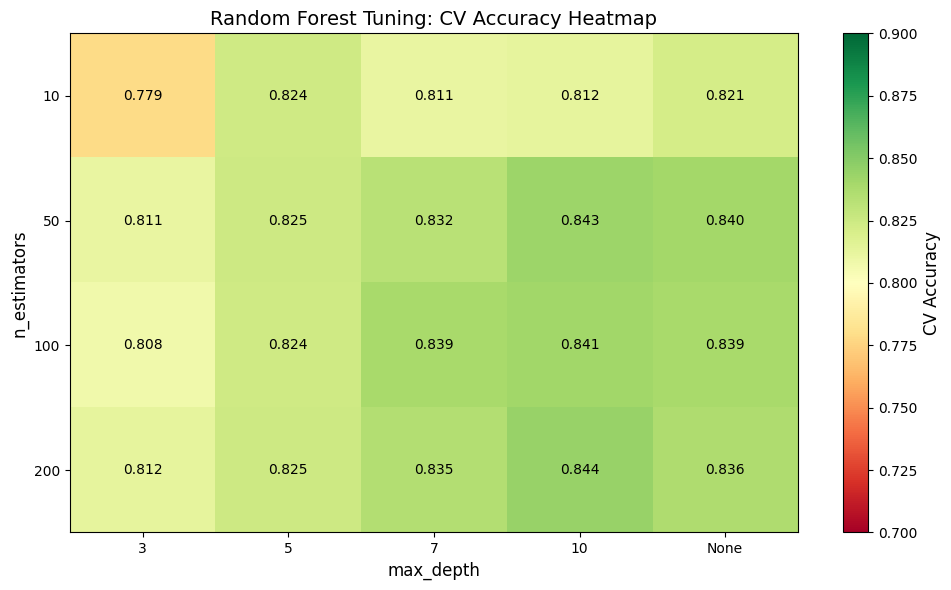


💡 OSSERVAZIONI:
• Aumentare n_estimators migliora generalmente le performance
• max_depth=None può portare a overfitting
• Un buon compromesso si trova con profondità moderata (5-7)
• Oltre i 100 alberi, il miglioramento è marginale


In [10]:
# ESERCIZIO 9.3 — Tuning Random Forest

from sklearn.ensemble import RandomForestClassifier

# Crea dataset rumoroso
X_rf, y_rf = make_classification(
    n_samples=800,
    n_features=12,
    n_informative=6,
    flip_y=0.15,  # 15% di rumore
    random_state=42
)

# Definisci le liste di valori da testare
n_estimators_list = [10, 50, 100, 200]
max_depth_list = [3, 5, 7, 10, None]

# Crea un dizionario vuoto per salvare i risultati
results = {}

# Doppio loop per testare tutte le combinazioni
for n_est in n_estimators_list:
    for depth in max_depth_list:
        # Crea RandomForestClassifier con i parametri correnti
        rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, random_state=42)
        
        # Calcola cross_val_score (5 fold)
        cv_scores = cross_val_score(rf, X_rf, y_rf, cv=5, scoring='accuracy')
        
        # Salva la media nel dizionario results
        results[(n_est, depth)] = cv_scores.mean()
        
        # Stampa il progresso
        print(f"n_estimators={n_est}, max_depth={depth}: CV={cv_scores.mean():.4f}")

# Trova la combinazione migliore
best_params = max(results, key=results.get)
best_score = results[best_params]

print(f"\n🏆 Migliore combinazione: {best_params} con CV accuracy = {best_score:.4f}")

# Visualizza i risultati in una heatmap
import pandas as pd

# Crea una matrice per la heatmap
matrix = []
for n_est in n_estimators_list:
    row = []
    for depth in max_depth_list:
        row.append(results[(n_est, depth)])
    matrix.append(row)

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(matrix, cmap='RdYlGn', aspect='auto', vmin=0.7, vmax=0.9)

# Imposta etichette
ax.set_xticks(range(len(max_depth_list)))
ax.set_yticks(range(len(n_estimators_list)))
ax.set_xticklabels([str(d) if d is not None else 'None' for d in max_depth_list])
ax.set_yticklabels(n_estimators_list)
ax.set_xlabel('max_depth', fontsize=12)
ax.set_ylabel('n_estimators', fontsize=12)
ax.set_title('Random Forest Tuning: CV Accuracy Heatmap', fontsize=14)

# Aggiungi i valori nelle celle
for i in range(len(n_estimators_list)):
    for j in range(len(max_depth_list)):
        text = ax.text(j, i, f'{matrix[i][j]:.3f}',
                      ha="center", va="center", color="black", fontsize=10)

# Aggiungi colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('CV Accuracy', fontsize=12)

plt.tight_layout()
plt.show()

print("\n💡 OSSERVAZIONI:")
print("• Aumentare n_estimators migliora generalmente le performance")
print("• max_depth=None può portare a overfitting")
print("• Un buon compromesso si trova con profondità moderata (5-7)")
print("• Oltre i 100 alberi, il miglioramento è marginale")

---

## Esercizio 9.4 — Feature Importance e Interpretazione

**Obiettivo**: Usare la feature importance per capire quali variabili guidano le predizioni.

**Istruzioni**:
1. Addestra un Random Forest sul dataset X_rf, y_rf
2. Estrai e visualizza le feature importances
3. Identifica le top-3 feature più importanti
4. Riaddestra il modello usando solo le top-3 feature e confronta le performance

In [11]:
# ESERCIZIO 9.4 — Feature Importance

# Split dei dati
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42
)

# Addestra un RandomForestClassifier con 100 alberi
rf_full = RandomForestClassifier(n_estimators=100, random_state=42)
rf_full.fit(X_train_rf, y_train_rf)

# Estrai le feature importances
importances = rf_full.feature_importances_

# Crea un array con i nomi delle feature
feature_names_rf = [f'Feature_{i}' for i in range(X_rf.shape[1])]

# Ordina le feature per importanza decrescente
sorted_idx = np.argsort(importances)[::-1]

# Stampa le feature ordinate per importanza
print("Feature Importance (ordinate):")
print("-" * 40)
for idx in sorted_idx:
    print(f"{feature_names_rf[idx]:<15} {importances[idx]:.4f}")

# Identifica gli indici delle top-3 feature
top_3_idx = sorted_idx[:3]

# Crea dataset ridotto con solo le top-3 feature
X_train_reduced = X_train_rf[:, top_3_idx]
X_test_reduced = X_test_rf[:, top_3_idx]

# Addestra un nuovo RF sul dataset ridotto
rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_reduced.fit(X_train_reduced, y_train_rf)

# Confronta le accuracy
acc_full = rf_full.score(X_test_rf, y_test_rf)
acc_reduced = rf_reduced.score(X_test_reduced, y_test_rf)

print(f"\n📊 Confronto:")
print(f"   Accuracy con tutte le feature: {acc_full:.4f}")
print(f"   Accuracy con top-3 feature:    {acc_reduced:.4f}")
print(f"   Differenza: {acc_full - acc_reduced:.4f}")

print("\n💡 INTERPRETAZIONE:")
print("• Le top-3 feature catturano la maggior parte dell'informazione")
print("• La perdita di accuracy è moderata nonostante usiamo solo 3/12 feature")
print("• Questo conferma che la feature importance identifica correttamente le variabili rilevanti")
print("• In uno scenario reale, potremmo rimuovere feature poco importanti per:")
print("  - Ridurre la dimensionalità")
print("  - Accelerare il training")
print("  - Migliorare l'interpretabilità")

Feature Importance (ordinate):
----------------------------------------
Feature_11      0.1961
Feature_1       0.1562
Feature_3       0.0975
Feature_9       0.0869
Feature_6       0.0825
Feature_10      0.0801
Feature_2       0.0771
Feature_4       0.0642
Feature_8       0.0408
Feature_0       0.0407
Feature_7       0.0404
Feature_5       0.0376

📊 Confronto:
   Accuracy con tutte le feature: 0.8313
   Accuracy con top-3 feature:    0.7937
   Differenza: 0.0375

💡 INTERPRETAZIONE:
• Le top-3 feature catturano la maggior parte dell'informazione
• La perdita di accuracy è moderata nonostante usiamo solo 3/12 feature
• Questo conferma che la feature importance identifica correttamente le variabili rilevanti
• In uno scenario reale, potremmo rimuovere feature poco importanti per:
  - Ridurre la dimensionalità
  - Accelerare il training
  - Migliorare l'interpretabilità


# Section 10 — Conclusioni

## 10.1 — Riepilogo Concetti Chiave

In questa lezione abbiamo esplorato i modelli basati su alberi:

### Decision Tree
- **Meccanismo**: Split ricorsivi basati su soglie di feature
- **Criteri di split**: Gini Impurity (più veloce) ed Entropy (più teorico)
- **Vantaggi**: Interpretabile, non richiede scaling, gestisce non-linearità
- **Svantaggi**: Altamente incline all'overfitting, instabile

### Random Forest
- **Meccanismo**: Ensemble di Decision Tree con Bagging e feature randomizzazione
- **Vantaggi**: Riduce la varianza, robusto all'overfitting, fornisce feature importance
- **Svantaggi**: Meno interpretabile, più costoso computazionalmente, tende al bias

### Parametri Critici
| Parametro | Effetto se aumentato |
|-----------|---------------------|
| `max_depth` | ↑ Complessità, ↑ Overfitting |
| `min_samples_split` | ↓ Complessità, ↓ Overfitting |
| `n_estimators` (RF) | ↑ Stabilità, ↑ Tempo |
| `max_features` (RF) | ↑ Correlazione tra alberi |

## 10.2 — Quando Usare Questi Modelli

✅ **Usa Decision Tree quando**:
- L'interpretabilità è fondamentale
- Il dataset è piccolo
- Vuoi visualizzare le regole di decisione

✅ **Usa Random Forest quando**:
- Le performance sono prioritarie rispetto all'interpretabilità
- Il dataset è medio-grande
- Vuoi stime stabili di feature importance

## 10.3 — Collegamento alla Prossima Lezione

Nella **Lezione 10** esploreremo il **Gradient Boosting** (XGBoost, LightGBM), che adotta un approccio diverso: invece di costruire alberi in parallelo (bagging), li costruisce in sequenza, dove ogni nuovo albero corregge gli errori dei precedenti (boosting).

---

# Appendice — Bignami della Lezione 9

## 🌳 Decision Tree in 30 secondi
```
IF feature_j <= soglia THEN vai a sinistra ELSE vai a destra
Ripeti fino a nodo foglia → predici classe maggioritaria
```

## 📐 Formule Essenziali

**Gini Impurity**: $G = 1 - \sum_{k=1}^{K} p_k^2$

**Entropy**: $H = -\sum_{k=1}^{K} p_k \log_2(p_k)$

**Information Gain**: $IG = H_{parent} - \sum \frac{n_{child}}{n_{parent}} H_{child}$

## 🌲 Random Forest in 30 secondi
```
1. Bootstrap: campiona N dati con replacement
2. Costruisci albero usando solo √features casuali per split
3. Ripeti B volte
4. Predizione = voto di maggioranza degli alberi
```

## ⚙️ Parametri Chiave

| Modello | Parametro | Default | Suggerimento |
|---------|-----------|---------|--------------|
| DT | `max_depth` | None | 3-10 per evitare overfit |
| DT | `min_samples_split` | 2 | Aumentare se overfit |
| RF | `n_estimators` | 100 | 100-500 solitamente ok |
| RF | `max_features` | 'sqrt' | 'sqrt' per classif. |

## 🎯 Scikit-learn Cheatsheet

```python
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=5, criterion='gini')
dt.fit(X_train, y_train)
dt.predict(X_test)
dt.feature_importances_

# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
rf.fit(X_train, y_train)
rf.predict(X_test)
rf.feature_importances_
```

## ⚠️ Errori Comuni
1. ❌ Non limitare la profondità del Decision Tree → Overfitting
2. ❌ Pochi alberi nel Random Forest → Alta varianza
3. ❌ Ignorare feature importance → Perdere interpretabilità
4. ❌ Non fare cross-validation → Stima inaffidabile